In [1]:
%%capture
%run table.ipynb

# Compose a function to calculate the shock population of one run

In [2]:
df_w.head()

,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
W1,960,10,1.56e-10,0,1.04,28.8,0.111,inf,inf,1,2.63,4.45,49.9,noise_c10nh960Buinf
W2,1920,10,9.68e-13,0,1.06,57.7,0.112,inf,inf,1,3.01,4.66,49.8,noise_c10nh1920Buinf
W3,3840,10,6e-15,0,1.1,115,0.113,inf,inf,1,3.6,5.22,49.9,noise_c10nh3840Buinf
W4,7680,10,3.72e-17,0,1.18,231,0.116,inf,inf,1,4.5,6.12,16.9,noise_c10nh7680Buinf
W5,960,20,1.56e-10,0,1,28.8,0.055,inf,inf,1,3.12,4.88,49.9,noise_c20nh960Buinf


In [4]:
df = df_w[df_w["$n$"] < 4000]
df

,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
W1,960,10,1.56e-10,0,1.04,28.8,0.111,inf,inf,1,2.63,4.45,49.9,noise_c10nh960Buinf
W2,1920,10,9.68e-13,0,1.06,57.7,0.112,inf,inf,1,3.01,4.66,49.8,noise_c10nh1920Buinf
W3,3840,10,6e-15,0,1.1,115,0.113,inf,inf,1,3.6,5.22,49.9,noise_c10nh3840Buinf
W5,960,20,1.56e-10,0,1,28.8,0.055,inf,inf,1,3.12,4.88,49.9,noise_c20nh960Buinf
W6,1920,20,9.69e-13,0,1.02,57.7,0.0553,inf,inf,1,3.64,5.61,120,noise_c20nh1920Buinf
W7,3840,20,6.01e-15,0,1.08,115,0.0563,inf,inf,1,4.49,6.92,120,noise_c20nh3840Buinf
W9,960,40,1.56e-10,0,0.996,28.8,0.0274,inf,inf,1,3.95,6.02,49.8,noise_c40nh960Buinf
W10,1920,40,9.68e-13,0,0.998,57.7,0.0274,inf,inf,1,4.78,7.12,49.8,noise_c40nh1920Buinf
W11,3840,40,6e-15,0,1.06,115,0.028,inf,inf,1,6.07,8.72,49.8,noise_c40nh3840Buinf
W12,960,100,1.56e-10,0,0.999,28.8,0.011,inf,inf,1,5.92,8.72,49.8,noise_c100nh960Buinf


In [6]:
set(df["$n$"])

{960, 1920, 3840}

In [10]:
short = df.iloc[4]["short name"]
paths_sim[short]

'/media/avmo/lacie/13KTH/noise/SW1Lwaves_NOISE2_c=20_L=50.x50._1920x1920_2016-09-27_18-44-40'

In [11]:
%%capture
from fluidsim import load_state_phys_file

sim = load_state_phys_file(paths_sim[short], merge_missing_params=True)

In [7]:
%matplotlib inline
# from scipy.signal import find_peaks, find_peaks_cwt
from peakutils import indexes
from scipy import ndimage as ndi
import matplotlib.pyplot as plt


def detect_shocks(sim, i0=None, i1=None, debug=False, **kwargs):
    div = sim.state.get_var("div")
    if i0 is not None:
        div1d = div[i0, :]
    elif i1 is not None:
        div1d = div[:, i1]
    else:
        raise ValueError

    div1d_orig = div1d
        
    # filter
    height = (div1d.min(), np.median(div1d))
    # peaks, _ = find_peaks(div1d, height=height, **kwargs)
    peaks = indexes(-div1d, thres=0.5, min_dist=3)
    if debug:
        print("Height =",height)
        print(f"Detected {len(peaks)} peaks")
        plt.figure(dpi=150)
        x = sim.oper.x_seq
        plt.plot(x, div1d_orig, 'k', label="original div")
        # plt.plot(div1d, 'g--', label="preprocessed div")    
        plt.plot(x[peaks], div1d[peaks], "x")
        plt.xlabel("$x$")
        plt.ylabel(r"$\nabla.\bf u$")
        plt.legend()
    else:
        return peaks

In [12]:
sim.output.path_run

'/media/avmo/lacie/13KTH/noise/SW1Lwaves_NOISE2_c=20_L=50.x50._1920x1920_2016-09-27_18-44-40'

Height = (-101.58373131210391, 1.5029331490423052)
Detected 9 peaks


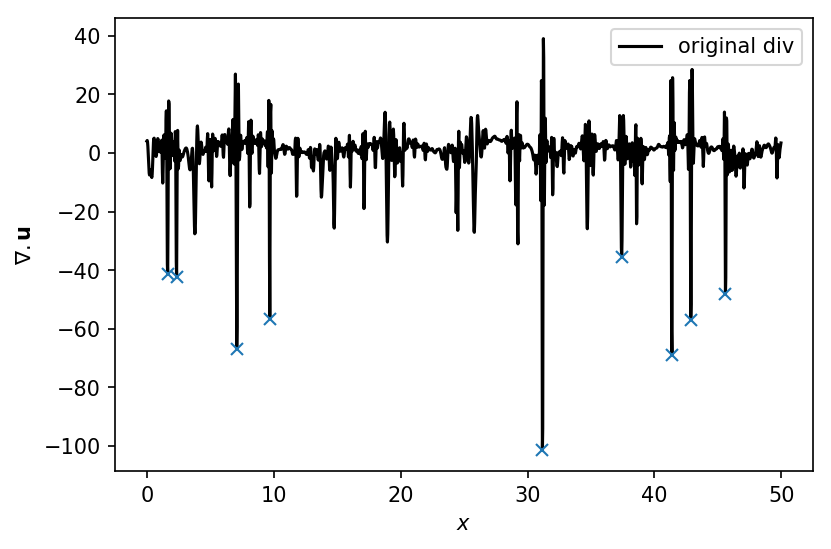

In [13]:
detect_shocks(sim, sim.oper.nx_seq // 2, debug=True)

In [14]:
def avg_shock_seperation_1d(sim, i0=None, i1=None):
    peaks = detect_shocks(sim, i0, i1)
    x_peaks = sim.oper.x_seq[peaks]
    dx_peaks = x_peaks[1:] - x_peaks[:-1]
    return dx_peaks.mean()

avg_shock_seperation_1d(sim, sim.oper.nx // 2)

5.494791666666667

/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


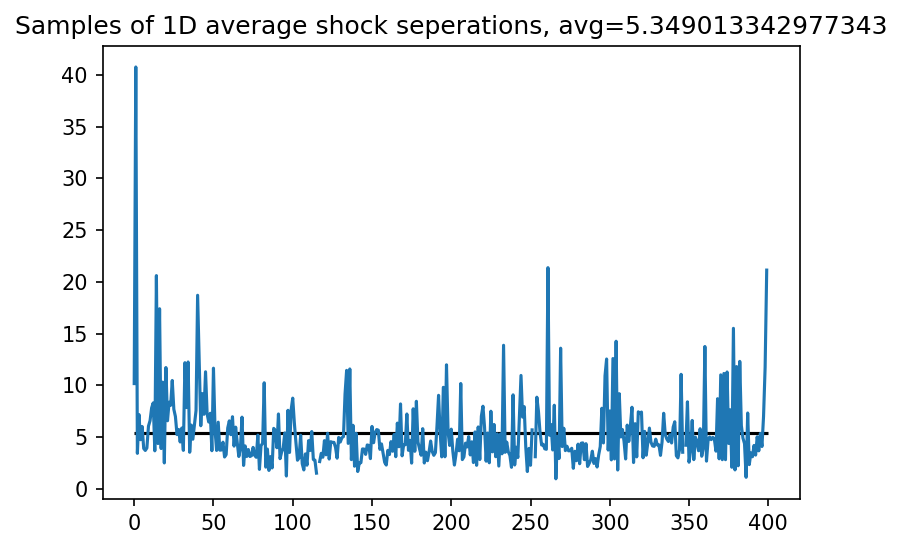

In [15]:
def avg_shock_seperation(sim, num_samples=200, averaged=True):
    ds = []
    for i in np.linspace(0, sim.oper.nx_seq-1, num_samples, dtype=int):
        ds0 = avg_shock_seperation_1d(sim, i0=i)
        ds1 = avg_shock_seperation_1d(sim, i1=i)
        ds.extend([ds0, ds1])
    if averaged:
        return np.nanmean(ds)
    else:
        return ds

ds_avg = avg_shock_seperation(sim, 200, averaged=False)
plt.figure(dpi=150)
ds_avg2 = np.nanmean(ds_avg)
plt.title(f"Samples of 1D average shock seperations, avg={ds_avg2}")
plt.hlines([ds_avg2], 0, len(ds_avg))
plt.plot(ds_avg)

In [16]:
def avg_shock_seperation_from_shortname(short_name):
    path = paths_sim[short_name]
    sim = fls.load_state_phys_file(path, merge_missing_params=True)
    return avg_shock_seperation(sim)

In [18]:
%%capture
result = df["short name"].apply(avg_shock_seperation_from_shortname)

In [19]:
result

W1     7.74
W2     6.13
W3     6.35
W5     5.56
W6     5.35
W7     5.75
W9     3.86
W10    3.87
W11    4.69
W12    2.27
W13    3.29
W14    3.11
W16    1.34
W17    1.35
W18    1.52
W19     1.1
W20   0.971
Name: short name, dtype: float64

In [48]:
from base import _k_f
Lf = pl.pi / _k_f(sim.params)
df["shock separation"] = result / Lf
df.head()

/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name,shock separation
W1,960,10,1.56e-10,0,1.04,28.8,0.111,inf,inf,1,2.63,4.45,49.9,noise_c10nh960Buinf,1.86
W2,1920,10,9.68e-13,0,1.06,57.7,0.112,inf,inf,1,3.01,4.66,49.8,noise_c10nh1920Buinf,1.47
W3,3840,10,6e-15,0,1.1,115,0.113,inf,inf,1,3.6,5.22,49.9,noise_c10nh3840Buinf,1.52
W5,960,20,1.56e-10,0,1,28.8,0.055,inf,inf,1,3.12,4.88,49.9,noise_c20nh960Buinf,1.33
W6,1920,20,9.69e-13,0,1.02,57.7,0.0553,inf,inf,1,3.64,5.61,120,noise_c20nh1920Buinf,1.28


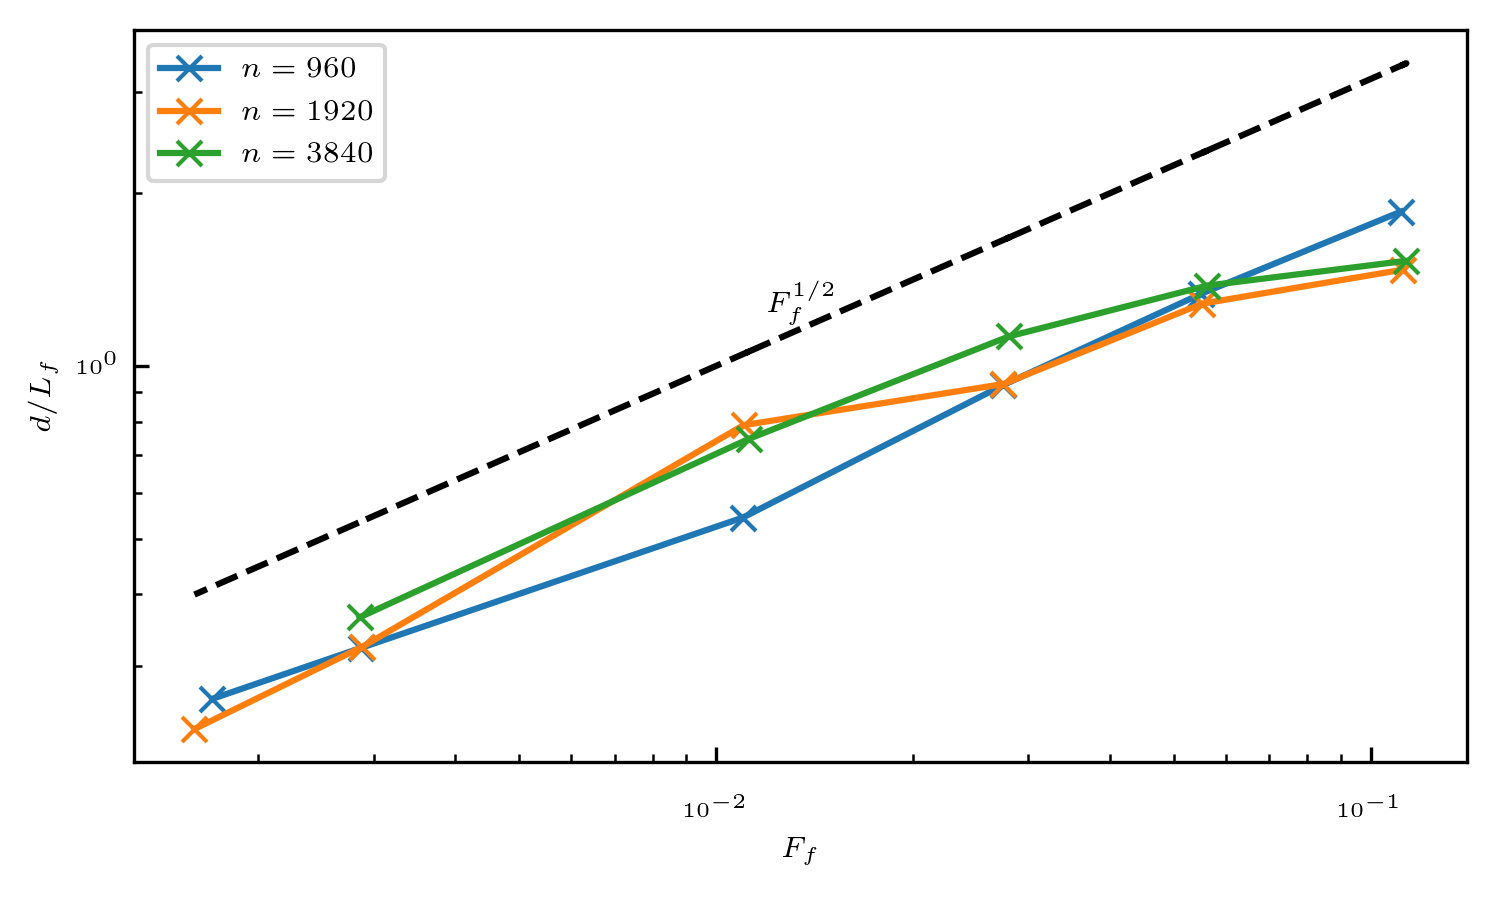

In [56]:
%matplotlib inline
from base import matplotlib_rc
matplotlib_rc()
fig, ax = plt.subplots(figsize=(5,3))
for n, grp in df.groupby("$n$"):
    grp.plot(r'$F_f$', 'shock separation', style="x-", ax=ax, label=f"$n={n}$", loglog=True)

# ax.loglog(df[r'$c$'], 50./df[r'$c$'], label="$c^{-1}$")
# ax.loglog(df[r'$c$'], 50./df[r'$c$'] ** 0.5, 'k', label="")
ax.loglog(df[r'$F_f$'], 10. * df[r'$F_f$'] ** 0.5, 'k--', label="")
ax.text(1.2e-2, 1.2, r"$F_f ^ {1/2}$")
ax.set_ylabel("$d / L_f$")
ax.legend()
fig.tight_layout()
plt.show()

In [57]:
fig.savefig("../Pyfig/fig_shock_sep.pdf")